<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/Ordinary_kriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pykrige

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 6.2 MB/s eta 0:00:00


In [2]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.6 MB/s eta 0:00:00


In [3]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 17.0 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pykrige.ok import OrdinaryKriging
from tqdm import tqdm
import time
from joblib import Parallel, delayed

# Start Timer
start_time = time.time()

# Load Data
print("Loading data...")
data = pd.read_csv('basePM25nearest_grid.csv')
model_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')

# Extract Model Data
model_lons = model_data['lon'].values
model_lats = model_data['lat'].values
model_values = model_data['SURF_ug_PM25_rh50'].values[0].astype(np.float32)  # Use float32 to reduce memory usage

# Extract Station Data
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].copy()
stations_data['nearest_SURF_ug_PM25_rh50'] = data['nearest_SURF_ug_PM25_rh50']

# Compute Bias
stations_data['bias'] = stations_data['SURF_ug_PM25_rh50'] - stations_data['nearest_SURF_ug_PM25_rh50']

# Optimized Kriging Model Selection with Parallel Processing
def evaluate_kriging_model(model, lon, lat, values):
    try:
        OK = OrdinaryKriging(lon, lat, values, variogram_model=model, verbose=False, enable_plotting=False)
        _, error = OK.execute('grid', np.linspace(lon.min(), lon.max(), 20), np.linspace(lat.min(), lat.max(), 20))
        return model, np.nanmean(error)
    except:
        return model, float('inf')

print("Selecting the best Kriging model using limited parallel processing...")
models = ['spherical', 'linear', 'exponential', 'gaussian']
results = Parallel(n_jobs=4)(delayed(evaluate_kriging_model)(model, stations_data['lon'].values, stations_data['lat'].values, stations_data['bias'].values) for model in models)
best_model = min(results, key=lambda x: x[1])[0]
print(f"Best selected variogram model: {best_model}")

# Function for Block Kriging with Shape Padding
def kriging_block(lon_range, lat_range, stations_data, best_model, shape):
    OK_bias = OrdinaryKriging(
        stations_data['lon'].values,
        stations_data['lat'].values,
        stations_data['bias'].values,
        variogram_model=best_model,
        verbose=False,
        enable_plotting=False
    )
    z_bias, _ = OK_bias.execute('grid', lon_range, lat_range)

    # Ensure all blocks have the same shape
    padded_bias = np.full(shape, np.nan, dtype=np.float32)  # Fill missing values with NaN
    padded_bias[:z_bias.shape[0], :z_bias.shape[1]] = z_bias
    return padded_bias

# Define Grid Blocks for Parallel Execution
num_blocks = 4  # Number of blocks to divide grid into
lon_splits = np.array_split(model_lons, num_blocks)
lat_splits = np.array_split(model_lats, num_blocks)

# Find max block shape for padding
max_rows = max(len(lat) for lat in lat_splits)
max_cols = max(len(lon) for lon in lon_splits)
block_shape = (max_rows, max_cols)

print("Interpolating bias using parallel Block Kriging with real-time progress...")
progress_bar = tqdm(total=num_blocks**2, desc="Kriging Progress", position=0, leave=True)

# Perform Block Kriging in Parallel
results = []
for i in range(num_blocks):
    row_blocks = []
    for j in range(num_blocks):
        row_blocks.append(kriging_block(lon_splits[j], lat_splits[i], stations_data, best_model, block_shape))
        progress_bar.update(1)  # Update progress bar in the main process
    results.append(row_blocks)
progress_bar.close()

# Concatenate blocks properly
z_bias = np.vstack([np.hstack(row) for row in results])

# Trim the final result to match the original shape
z_bias = z_bias[:len(model_lats), :len(model_lons)]

# Apply Bias Correction
print("Applying bias correction to model data...")
corrected_values = model_values + z_bias
corrected_data = model_data.copy()
corrected_data['SURF_ug_PM25_rh50_corrected'] = (['time', 'lat', 'lon'], corrected_values[np.newaxis, :, :])

# Save Corrected Data
print("Saving corrected NetCDF file...")
corrected_data.to_netcdf('BC_PERT_PM25_rh50_Y_OK.nc')

# End Timer
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Loading data...
Selecting the best Kriging model using limited parallel processing...
Best selected variogram model: spherical
Interpolating bias using parallel Block Kriging with real-time progress...


Kriging Progress: 100%|██████████| 16/16 [07:59<00:00, 29.97s/it]


Applying bias correction to model data...
Saving corrected NetCDF file...
Total execution time: 508.38 seconds


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


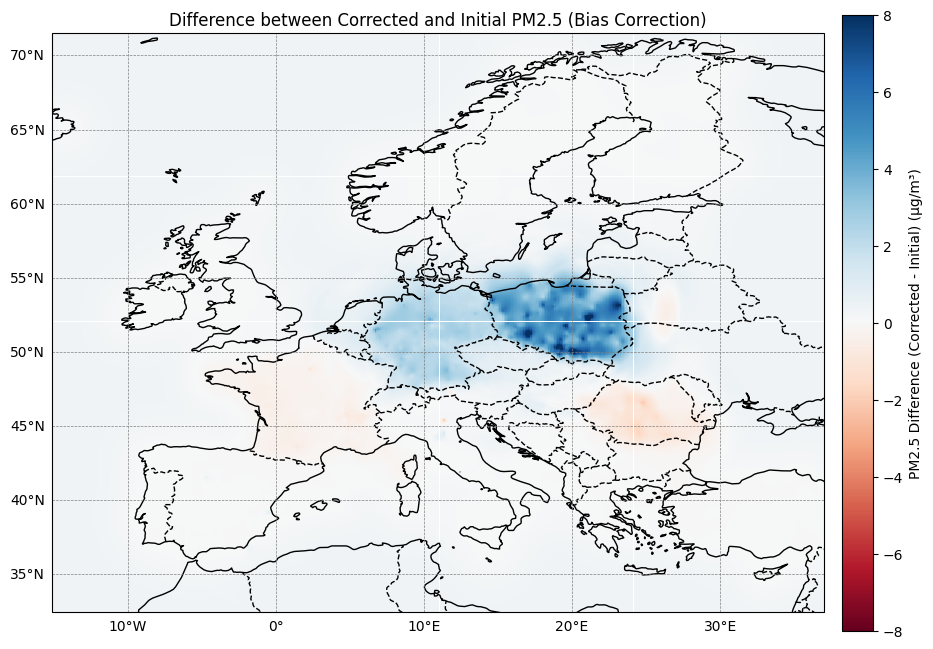

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "BC_PERT_PM25_rh50_Y_OK.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()
